# Performance Tuning

Chapter 18 covered the Spark user interface (UI) and basic first-aid for your Spark Application.
Using the tools outlined in that chapter, you should be able to ensure that your jobs run reliably.
However, sometimes you’ll also need them to run faster or more efficiently for a variety of
reasons. That’s what this chapter is about. Here, we present a discussion of some of the
performance choices that are available to make your jobs run faster.

Just as with monitoring, there are a number of different levels that you can try to tune at. For
instance, if you had an extremely fast network, that would make many of your Spark jobs faster
because shuffles are so often one of the costlier steps in a Spark job. Most likely, you won’t have
much ability to control such things; therefore, we’re going to discuss the things you can control
through code choices or configuration.

There are a variety of different parts of Spark jobs that you might want to optimize, and it’s
valuable to be specific. Following are some of the areas:
* Code-level design choices (e.g., RDDs versus DataFrames)
* Data at rest
* Joins
* Aggregations
* Data in flight
* Individual application properties
* Inside of the Java Virtual Machine (JVM) of an executor
* Worker nodes
* Cluster and deployment properties

This list is by no means exhaustive, but it does at least ground the conversation and the topics
that we cover in this chapter. Additionally, there are two ways of trying to achieve the execution
characteristics that we would like out of Spark jobs. We can either do so indirectly by setting
configuration values or changing the runtime environment. These should improve things across
Spark Applications or across Spark jobs. Alternatively, we can try to directly change execution
characteristic or design choices at the individual Spark job, stage, or task level. These kinds of
fixes are very specific to that one area of our application and therefore have limited overall
impact. There are numerous things that lie on both sides of the indirect versus direct divide, and
we will draw lines in the sand accordingly.

One of the best things you can do to figure out how to improve performance is to implement
good monitoring and job history tracking. Without this information, it can be difficult to know
whether you’re really improving job performance.

## Indirect Performance Enhancements
As discussed, there are a number of indirect enhancements that you can perform to help your
Spark jobs run faster. We’ll skip the obvious ones like “improve your hardware” and focus more
on the things within your control.

### Design Choices
Although good design choices seem like a somewhat obvious way to optimize performance, we
often don’t prioritize this step in the process. When designing your applications, making good
design choices is very important because it not only helps you to write better Spark applications
but also to get them to run in a more stable and consistent manner over time and in the face of
external changes or variations. We’ve already discussed some of these topics earlier in the book,
but we’ll summarize some of the fundamental ones again here.
#### Scala versus Java versus Python versus R
This question is nearly impossible to answer in the general sense because a lot will depend on
your use case. For instance, if you want to perform some single-node machine learning after
performing a large ETL job, we might recommend running your Extract, Transform, and Load
(ETL) code as SparkR code and then using R’s massive machine learning ecosystem to run your
single-node machine learning algorithms. This gives you the best of both worlds and takes
advantage of the strength of R as well as the strength of Spark without sacrifices. As we
mentioned numerous times, Spark’s Structured APIs are consistent across languages in terms of
speed and stability. That means that you should code with whatever language you are most
comfortable using or is best suited for your use case.

Things do get a bit more complicated when you need to include custom transformations that
cannot be created in the Structured APIs. These might manifest themselves as RDD
transformations or user-defined functions (UDFs). If you’re going to do this, R and Python are
not necessarily the best choice simply because of how this is actually executed. It’s also more
difficult to provide stricter guarantees of types and manipulations when you’re defining functions
that jump across languages. We find that using Python for the majority of the application, and
porting some of it to Scala or writing specific UDFs in Scala as your application evolves, is a
powerful technique—it allows for a nice balance between overall usability, maintainability, and
performance.
#### DataFrames versus SQL versus Datasets versus RDDs
This question also comes up frequently. The answer is simple. Across all languages,
DataFrames, Datasets, and SQL are equivalent in speed. This means that if you’re using
DataFrames in any of these languages, performance is equal. However, if you’re going to be
defining UDFs, you’ll take a performance hit writing those in Python or R, and to some extent a
lesser performance hit in Java and Scala. If you want to optimize for pure performance, it would
behoove you to try and get back to DataFrames and SQL as quickly as possible. Although all
DataFrame, SQL, and Dataset code compiles down to RDDs, Spark’s optimization engine will
write “better” RDD code than you can manually and certainly do it with orders of magnitude less
effort. Additionally, you will lose out on new optimizations that are added to Spark’s SQL
engine every release.

Lastly, if you want to use RDDs, we definitely recommend using Scala or Java. If that’s not
possible, we recommend that you restrict the “surface area” of RDDs in your application to the
bare minimum. That’s because when Python runs RDD code, it’s serializes a lot of data to and
from the Python process. This is very expensive to run over very big data and can also decrease
stability.

Although it isn’t exactly relevant to performance tuning, it’s important to note that there are also
some gaps in what functionality is supported in each of Spark’s languages. We discussed this in
Chapter 16.

### Object Serialization in RDDs
In Part III, we briefly discussed the serialization libraries that can be used within RDD
transformations. When you’re working with custom data types, you’re going to want to serialize
them using Kryo because it’s both more compact and much more efficient than Java
serialization. However, this does come at the inconvenience of registering the classes that you
will be using in your application.

You can use Kryo serialization by setting spark.serializer to
org.apache.spark.serializer.KryoSerializer. You will also need to explicitly register the
classes that you would like to register with the Kryo serializer via the
spark.kryo.classesToRegister configuration. There are also a number of advanced
parameters for controlling this in greater detail that are described in the Kryo documentation.

To register your classes, use the SparkConf that you just created and pass in the names of your
classes:

conf.registerKryoClasses(Array(classOf[MyClass1], classOf[MyClass2]))

### Cluster Configurations
This area has huge potential benefits but is probably one of the more difficult to prescribe
because of the variation across hardware and use cases. In general, monitoring how the machines
themselves are performing will be the most valuable approach toward optimizing your cluster
configurations, especially when it comes to running multiple applications (whether they are
Spark or not) on a single cluster.

#### Cluster/application sizing and sharing
This somewhat comes down to a resource sharing and scheduling problem; however, there are a
lot of options for how you want to share resources at the cluster level or at the application level.
Take a look at the configurations listed at the end of Chapter 16 as well as some configurations
in Chapter 17.
#### Dynamic allocation
Spark provides a mechanism to dynamically adjust the resources your application occupies based
on the workload. This means that your application can give resources back to the cluster if they
are no longer used, and request them again later when there is demand. This feature is
particularly useful if multiple applications share resources in your Spark cluster. This feature is
disabled by default and available on all coarse-grained cluster managers; that is, standalone
mode, YARN mode, and Mesos coarse-grained mode. If you’d like to enable this feature, you
should set spark.dynamicAllocation.enabled to true. The Spark documentation presents a
number of individual parameters that you can tune.

### Scheduling
Over the course of the previous chapters, we discussed a number of different potential
optimizations that you can take advantage of to either help Spark jobs run in parallel with
scheduler pools or help Spark applications run in parallel with something like dynamic allocation
or setting max-executor-cores. Scheduling optimizations do involve some research and
experimentation, and unfortunately there are not super-quick fixes beyond setting
spark.scheduler.mode to FAIR to allow better sharing of resources across multiple users, or
setting --max-executor-cores, which specifies the maximum number of executor cores that
your application will need. Specifying this value can ensure that your application does not take
up all the resources on the cluster. You can also change the default, depending on your cluster
manager, by setting the configuration spark.cores.max to a default of your choice. Cluster
managers also provide some scheduling primitives that can be helpful when optimizing multiple
Spark Applications, as discussed in Chapters 16 and 17.

### Data at Rest
More often that not, when you’re saving data it will be read many times as other folks in your
organization access the same datasets in order to run different analyses. Making sure that you’re
storing your data for effective reads later on is absolutely essential to successful big data
projects. This involves choosing your storage system, choosing your data format, and taking
advantage of features such as data partitioning in some storage formats.

#### File-based long-term data storage
There are a number of different file formats available, from simple comma-separated values
(CSV) files and binary blobs, to more sophisticated formats like Apache Parquet. One of the
easiest ways to optimize your Spark jobs is to follow best practices when storing data and choose
the most efficient storage format possible.

Generally you should always favor structured, binary types to store your data, especially when
you’ll be accessing it frequently. Although files like “CSV” seem well-structured, they’re very
slow to parse, and often also full of edge cases and pain points. For instance, improperly escaped
new-line characters can often cause a lot of trouble when reading a large number of files. The
most efficient file format you can generally choose is Apache Parquet. Parquet stores data in
binary files with column-oriented storage, and also tracks some statistics about each file that
make it possible to quickly skip data not needed for a query. It is well integrated with Spark
through the built-in Parquet data source.
#### Splittable file types and compression
Whatever file format you choose, you should make sure it is “splittable”, which means that
different tasks can read different parts of the file in parallel. We saw why this is important in
Chapter 18. When we read in the file, all cores were able to do part of the work. That’s because
the file was splittable. If we didn’t use a splittable file type—say something like a malformed
JSON file—we’re going to need to read in the entire file on a single machine, greatly reducing
parallelism.

The main place splittability comes in is compression formats. A ZIP file or TAR archive cannot
be split, which means that even if we have 10 files in a ZIP file and 10 cores, only one core can
read in that data because we cannot parallelize access to the ZIP file. This is a poor use of
resources. In contrast, files compressed using gzip, bzip2, or lz4 are generally splittable if they
were written by a parallel processing framework like Hadoop or Spark. For your own input data,
the simplest way to make it splittable is to upload it as separate files, ideally each no larger than a
few hundred megabytes.
#### Table partitioning
We discussed table partitioning in Chapter 9, and will only use this section as a reminder. Table
partitioning refers to storing files in separate directories based on a key, such as the date field in
the data. Storage managers like Apache Hive support this concept, as do many of Spark’s built-in
data sources. Partitioning your data correctly allows Spark to skip many irrelevant files when it
only requires data with a specific range of keys. For instance, if users frequently filter by “date”
or “customerId” in their queries, partition your data by those columns. This will greatly reduce
the amount of data that end users must read by most queries, and therefore dramatically increase
speed.

The one downside of partitioning, however, is that if you partition at too fine a granularity, it can
result in many small files, and a great deal of overhead trying to list all the files in the storage
system.
#### Bucketing
We also discussed bucketing in Chapter 9, but to recap, the essense is that bucketing your data
allows Spark to “pre-partition” data according to how joins or aggregations are likely to be
performed by readers. This can improve performance and stability because data can be
consistently distributed across partitions as opposed to skewed into just one or two. For instance,
if joins are frequently performed on a column immediately after a read, you can use bucketing to
ensure that the data is well partitioned according to those values. This can help prevent a shuffle
before a join and therefore help speed up data access. Bucketing generally works hand-in-hand
with partitioning as a second way of physically splitting up data.
#### The number of files
In addition to organizing your data into buckets and partitions, you’ll also want to consider the
number of files and the size of files that you’re storing. If there are lots of small files, you’re
going to pay a price listing and fetching each of those individual files. For instance, if you’re
reading a data from Hadoop Distributed File System (HDFS), this data is managed in blocks that
are up to 128 MB in size (by default). This means if you have 30 files, of 5 MB each, you’re
going to have to potentially request 30 blocks, even though the same data could have fit into 2
blocks (150 MB total).

Although there is not necessarily a panacea for how you want to store your data, the trade-off can
be summarized as such. Having lots of small files is going to make the scheduler work much
harder to locate the data and launch all of the read tasks. This can increase the network and
scheduling overhead of the job. Having fewer large files eases the pain off the scheduler but it
will also make tasks run longer. In this case, though, you can always launch more tasks than
there are input files if you want more parallelism—Spark will split each file across multiple tasks
assuming you are using a splittable format. In general, we recommend sizing your files so that
they each contain at least a few tens of megatbytes of data.

One way of controlling data partitioning when you write your data is through a write option
introduced in Spark 2.2. To control how many records go into each file, you can specify the
maxRecordsPerFile option to the write operation.
#### Data locality
Another aspect that can be important in shared cluster environments is data locality. Data locality
basically specifies a preference for certain nodes that hold certain data, rather than having to
exchange these blocks of data over the network. If you run your storage system on the same
nodes as Spark, and the system supports locality hints, Spark will try to schedule tasks close to
each input block of data. For example HDFS storage provides this option. There are several
configurations that affect locality, but it will generally be used by default if Spark detects that it
is using a local storage system. You will also see data-reading tasks marked as “local” in the
Spark web UI.
#### Statistics collection
Spark includes a cost-based query optimizer that plans queries based on the properties of the
input data when using the structured APIs. However, to allow the cost-based optimizer to make
these sorts of decisions, you need to collect (and maintain) statistics about your tables that it can
use. There are two kinds of statistics: table-level and column-level statistics. Statistics collection
is available only on named tables, not on arbitrary DataFrames or RDDs.

To collect table-level statistics, you can run the following command:

ANALYZE TABLE table_name COMPUTE STATISTICS

To collect column-level statistics, you can name the specific columns:

ANALYZE TABLE table_name COMPUTE STATISTICS FOR

COLUMNS column_name1, column_name2, ...

Column-level statistics are slower to collect, but provide more information for the cost-based
optimizer to use about those data columns. Both types of statistics can help with joins,
aggregations, filters, and a number of other potential things (e.g., automatically choosing when to
do a broadcast join). This is a fast-growing part of Spark, so different optimizations based on
statistics will likely be added in the future.

___NOTE___
You can follow the progress of cost-based optimization on its JIRA issue. You can also read through
the design document on SPARK-16026 to learn more about this feature. This is an active area of
development in Spark at the time of writing.

### Shuffle Configurations
Configuring Spark’s external shuffle service (discussed in Chapters 16 and 17) can often
increase performance because it allows nodes to read shuffle data from remote machines even
when the executors on those machines are busy (e.g., with garbage collection). This does come at
the cost of complexity and maintenance, however, so it might not be worth it in your
deployment. Beyond configuring this external service, there are also a number of configurations
for shuffles, such as the number of concurrent connections per executor, although these usually
have good defaults.

In addition, for RDD-based jobs, the serialization format has a large impact on shuffle
performance—always prefer Kryo over Java serialization, as described in “Object Serialization
in RDDs”. Furthermore, for all jobs, the number of partitions of a shuffle matters. If you have
too few partitions, then too few nodes will be doing work and there may be skew, but if you have
too many partitions, there is an overhead to launching each one that may start to dominate. Try to
aim for at least a few tens of megabytes of data per output partition in your shuffle.

### Memory Pressure and Garbage Collection
During the course of running Spark jobs, the executor or driver machines may struggle to
complete their tasks because of a lack of sufficient memory or “memory pressure.” This may
occur when an application takes up too much memory during execution or when garbage
collection runs too frequently or is slow to run as large numbers of objects are created in the
JVM and subsequently garbage collected as they are no longer used. One strategy for easing this
issue is to ensure that you’re using the Structured APIs as much as possible. These will not only
increase the efficiency with which your Spark jobs will execute, but it will also greatly reduce
memory pressure because JVM objects are never realized and Spark SQL simply performs the
computation on its internal format.

The Spark documentation includes some great pointers on tuning garbage collection for RDD
and UDF based applications, and we paraphrase the following sections from that information.
#### Measuring the impact of garbage collection
The first step in garbage collection tuning is to gather statistics on how frequently garbage
collection occurs and the amount of time it takes. You can do this by adding -verbose:gc -
XX:+PrintGCDetails -XX:+PrintGCTimeStamps to Spark’s JVM options using the
spark.executor.extraJavaOptions configuration parameter. The next time you run your
Spark job, you will see messages printed in the worker’s logs each time a garbage collection
occurs. These logs will be on your cluster’s worker nodes (in the stdout files in their work
directories), not in the driver.
#### Garbage collection tuning
To further tune garbage collection, you first need to understand some basic information about
memory management in the JVM:
* Java heap space is divided into two regions: Young and Old. The Young generation is
meant to hold short-lived objects whereas the Old generation is intended for objects
with longer lifetimes.
* The Young generation is further divided into three regions: Eden, Survivor1, and
Survivor2.

Here’s a simplified description of the garbage collection procedure:

1. When Eden is full, a minor garbage collection is run on Eden and objects that are alive
from Eden and Survivor1 are copied to Survivor2.
2. The Survivor regions are swapped.
3. If an object is old enough or if Survivor2 is full, that object is moved to Old.
4. Finally, when Old is close to full, a full garbage collection is invoked. This involves
tracing through all the objects on the heap, deleting the unreferenced ones, and moving
the others to fill up unused space, so it is generally the slowest garbage collection
operation.

The goal of garbage collection tuning in Spark is to ensure that only long-lived cached datasets
are stored in the Old generation and that the Young generation is sufficiently sized to store all
short-lived objects. This will help avoid full garbage collections to collect temporary objects
created during task execution. Here are some steps that might be useful.

Gather garbage collection statistics to determine whether it is being run too often. If a full
garbage collection is invoked multiple times before a task completes, it means that there isn’t
enough memory available for executing tasks, so you should decrease the amount of memory
Spark uses for caching (spark.memory.fraction).

If there are too many minor collections but not many major garbage collections, allocating more
memory for Eden would help. You can set the size of the Eden to be an over-estimate of how
much memory each task will need. If the size of Eden is determined to be E, you can set the size
of the Young generation using the option -Xmn=4/3*E. (The scaling up by 4/3 is to account for
space used by survivor regions, as well.)

As an example, if your task is reading data from HDFS, the amount of memory used by the task
can be estimated by using the size of the data block read from HDFS. Note that the size of a
decompressed block is often two or three times the size of the block. So if you want to have three
or four tasks’ worth of working space, and the HDFS block size is 128 MB, we can estimate size
of Eden to be 43,128 MB.

Try the G1GC garbage collector with -XX:+UseG1GC. It can improve performance in some
situations in which garbage collection is a bottleneck and you don’t have a way to reduce it
further by sizing the generations. Note that with large executor heap sizes, it can be important to
increase the G1 region size with -XX:G1HeapRegionSize.

Monitor how the frequency and time taken by garbage collection changes with the new settings.

Our experience suggests that the effect of garbage collection tuning depends on your application
and the amount of memory available. There are many more tuning options described online, but
at a high level, managing how frequently full garbage collection takes place can help in reducing
the overhead. You can specify garbage collection tuning flags for executors by setting
spark.executor.extraJavaOptions in a job’s configuration.

## Direct Performance Enhancements
In the previous section, we touched on some general performance enhancements that apply to all
jobs. Be sure to skim the previous couple of pages before jumping to this section and the
solutions here. These solutions here are intended as “band-aids” of sorts for issues with specific
stages or jobs, but they require inspecting and optimizing each stage or job separately.

### Parallelism
The first thing you should do whenever trying to speed up a specific stage is to increase the
degree of parallelism. In general, we recommend having at least two or three tasks per CPU core
in your cluster if the stage processes a large amount of data. You can set this via the
spark.default.parallelism property as well as tuning the spark.sql.shuffle.partitions
according to the number of cores in your cluster.

### Improved Filtering
Another frequent source of performance enhancements is moving filters to the earliest part of
your Spark job that you can. Sometimes, these filters can be pushed into the data sources
themselves and this means that you can avoid reading and working with data that is irrelevant to
your end result. Enabling partitioning and bucketing also helps achieve this. Always look to be
filtering as much data as you can early on, and you’ll find that your Spark jobs will almost
always run faster.

### Repartitioning and Coalescing
Repartition calls can incur a shuffle. However, doing some can optimize the overall execution of
a job by balancing data across the cluster, so they can be worth it. In general, you should try to
shuffle the least amount of data possible. For this reason, if you’re reducing the number of
overall partitions in a DataFrame or RDD, first try coalesce method, which will not perform a
shuffle but rather merge partitions on the same node into one partition. The slower repartition
method will also shuffle data across the network to achieve even load balancing. Repartitions can
be particularly helpful when performing joins or prior to a cache call. Remember that
repartitioning is not free, but it can improve overall application performance and parallelism of
your jobs.
#### Custom partitioning
If your jobs are still slow or unstable, you might want to explore performing custom partitioning
at the RDD level. This allows you to define a custom partition function that will organize the
data across the cluster to a finer level of precision than is available at the DataFrame level. This
is very rarely necessary, but it is an option. For more information, see Part III.

### User-Defined Functions (UDFs)
In general, avoiding UDFs is a good optimization opportunity. UDFs are expensive because they
force representing data as objects in the JVM and sometimes do this multiple times per record in
a query. You should try to use the Structured APIs as much as possible to perform your
manipulations simply because they are going to perform the transformations in a much more
efficient manner than you can do in a high-level language. There is also ongoing work to make
data available to UDFs in batches, such as the Vectorized UDF extension for Python that gives
your code multiple records at once using a Pandas data frame. We discussed UDFs and their
costs in Chapter 18

### Temporary Data Storage (Caching)
In applications that reuse the same datasets over and over, one of the most useful optimizations is
caching. Caching will place a DataFrame, table, or RDD into temporary storage (either memory
or disk) across the executors in your cluster, and make subsequent reads faster. Although caching
might sound like something we should do all the time, it’s not always a good thing to do. That’s
because caching data incurs a serialization, deserialization, and storage cost. For example, if you
are only going to process a dataset once (in a later transformation), caching it will only slow you
down.

The use case for caching is simple: as you work with data in Spark, either within an interactive
session or a standalone application, you will often want to reuse a certain dataset (e.g., a
DataFrame or RDD). For example, in an interactive data science session, you might load and
clean your data and then reuse it to try multiple statistical models. Or in a standalone application,
you might run an iterative algorithm that reuses the same dataset. You can tell Spark to cache a
dataset using the cache method on DataFrames or RDDs.

Caching is a lazy operation, meaning that things will be cached only as they are accessed. The
RDD API and the Structured API differ in how they actually perform caching, so let’s review the
gory details before going over the storage levels. When we cache an RDD, we cache the actual,
physical data (i.e., the bits). The bits. When this data is accessed again, Spark returns the proper
data. This is done through the RDD reference. However, in the Structured API, caching is done
based on the physical plan. This means that we effectively store the physical plan as our key (as
opposed to the object reference) and perform a lookup prior to the execution of a Structured job.
This can cause confusion because sometimes you might be expecting to access raw data but
because someone else already cached the data, you’re actually accessing their cached version.
Keep that in mind when using this feature.

There are different storage levels that you can use to cache your data, specifying what type of
storage to use. Table 19-1 lists the levels.
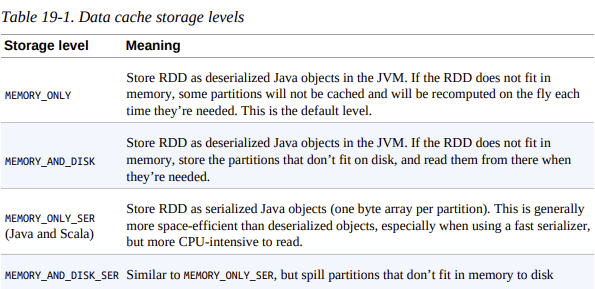
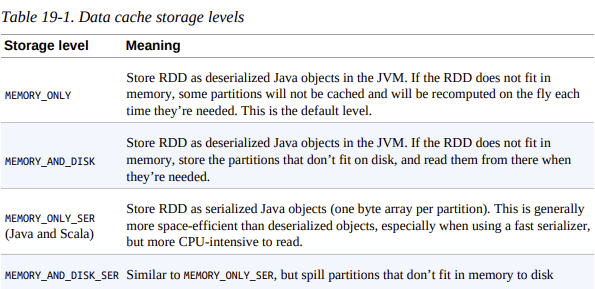
For more information on these options, take a look at “Configuring Memory Management”.

Figure 19-1 presents a simple illustrations of the process. We load an initial DataFrame from a
CSV file and then derive some new DataFrames from it using transformations. We can avoid
having to recompute the original DataFrame (i.e., load and parse the CSV file) many times by
adding a line to cache it along the way
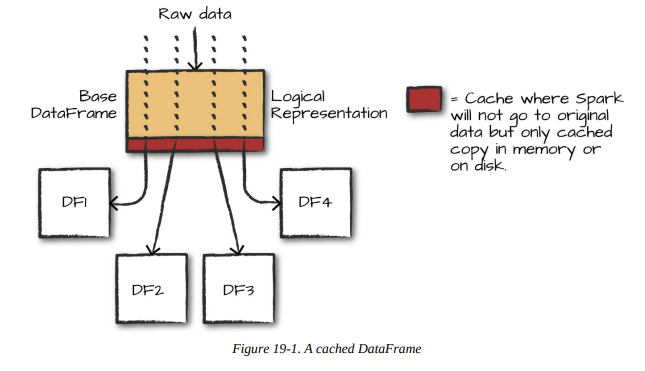
Now let’s walk through the code:
~~~
# in Python
# Original loading code that does *not* cache DataFrame
DF1 = spark.read.format("csv")\
.option("inferSchema", "true")\
.option("header", "true")\
.load("/data/flight-data/csv/2015-summary.csv")
DF2 = DF1.groupBy("DEST_COUNTRY_NAME").count().collect()
DF3 = DF1.groupBy("ORIGIN_COUNTRY_NAME").count().collect()
DF4 = DF1.groupBy("count").count().collect()
~~~
You’ll see here that we have our “lazily” created DataFrame (DF1), along with three other
DataFrames that access data in DF1. All of our downstream DataFrames share that common
parent (DF1) and will repeat the same work when we perform the preceding code. In this case,
it’s just reading and parsing the raw CSV data, but that can be a fairly intensive process,
especially for large datasets.

On my machine, those commands take a second or two to run. Luckily caching can help speed
things up. When we ask for a DataFrame to be cached, Spark will save the data in memory or on
disk the first time it computes it. Then, when any other queries come along, they’ll just refer to
the one stored in memory as opposed to the original file. You do this using the DataFrame’s
cache method:

DF1.cache()
DF1.count()

We used the count above to eagerly cache the data (basically perform an action to force Spark to
store it in memory), because caching itself is lazy—the data is cached only on the first time you
run an action on the DataFrame. Now that the data is cached, the previous commands will be
faster, as we can see by running the following code:
~~~
# in Python
DF2 = DF1.groupBy("DEST_COUNTRY_NAME").count().collect()
DF3 = DF1.groupBy("ORIGIN_COUNTRY_NAME").count().collect()
DF4 = DF1.groupBy("count").count().collect()
~~~
When we ran this code, it cut the time by more than half! This might not seem that wild, but
picture a large dataset or one that requires a lot of computation to create (not just reading in a
file). The savings can be immense. It’s also great for iterative machine learning workloads
because they’ll often need to access the same data a number of times, which we’ll see shortly.

The cache command in Spark always places data in memory by default, caching only part of the
dataset if the cluster’s total memory is full. For more control, there is also a persist method that
takes a StorageLevel object to specify where to cache the data: in memory, on disk, or both.

### Joins
Joins are a common area for optimization. The biggest weapon you have when it comes to
optimizing joins is simply educating yourself about what each join does and how it’s performed.
This will help you the most. Additionally, equi-joins are the easiest for Spark to optimize at this
point and therefore should be preferred wherever possible. Beyond that, simple things like trying
to use the filtering ability of inner joins by changing join ordering can yield large speedups.
Additionally, using broadcast join hints can help Spark make intelligent planning decisions when
it comes to creating query plans, as described in Chapter 8. Avoiding Cartesian joins or even full
outer joins is often low-hanging fruit for stability and optimizations because these can often be
optimized into different filtering style joins when you look at the entire data flow instead of just
that one particular job area. Lastly, following some of the other sections in this chapter can have
a significant effect on joins. For example, collecting statistics on tables prior to a join will help
Spark make intelligent join decisions. Additionally, bucketing your data appropriately can also
help Spark avoid large shuffles when joins are performed.

### Aggregations
For the most part, there are not too many ways that you can optimize specific aggregations
beyond filtering data before the aggregation having a sufficiently high number of partitions.
However, if you’re using RDDs, controlling exactly how these aggregations are performed (e.g.,
using reduceByKey when possible over groupByKey) can be very helpful and improve the speed
and stability of your code.
### Broadcast Variables
We touched on broadcast joins and variables in previous chapters, and these are a good option
for optimization. The basic premise is that if some large piece of data will be used across
multiple UDF calls in your program, you can broadcast it to save just a single read-only copy on
each node and avoid re-sending this data with each job. For example, broadcast variables may be
useful to save a lookup table or a machine learning model. You can also broadcast arbitrary
objects by creating broadcast variables using your SparkContext, and then simply refer to those
variables in your tasks, as we discussed in Chapter 14.

## Conclusion
There are many different ways to optimize the performance of your Spark Applications and
make them run faster and at a lower cost. In general, the main things you’ll want to prioritize are
(1) reading as little data as possible through partitioning and efficient binary formats, (2) making
sure there is sufficient parallellism and no data skew on the cluster using partitioning, and (3)
using high-level APIs such as the Structured APIs as much as possible to take already optimized
code. As with any other software optimization work, you should also make sure you are
optimizing the right operations for your job: the Spark monitoring tools described in Chapter 18
will let you see which stages are taking the longest time and focus your efforts on those. Once
you have identified the work that you believe can be optimized, the tools in this chapter will
cover the most important performance optimization opportunities for the majority of users.